In [1]:

from PIL import Image

Image.MAX_IMAGE_PIXELS = None  # remove decompression-limit check

In [25]:
import os
import glob
import tifffile
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.colors as mcolors

# Define overlay colors
colors = {
    'nucleus': '#1f77b4',   # blue
    'mitos':   '#ff7f0e',   # orange
    'lds':     '#2ca02c',   # green
    'au':      '#d62728'    # red
}

class SampleMasks:
    """
    Loads EM and mask images for a given sample into memory.
    Call `display(...)` to crop and overlay and `display_em()` for a full EM reference with ticks.
    """
    def __init__(self, sample_id,
                 em_base='/Volumes/Chris_SSD/file_shuttle/ImmunoEM-exports',
                 analysis_base='/Volumes/Chris_SSD/ImmunoEM-Analysis'):
        sample_id = str(sample_id)
        self.sample_id = sample_id

        # Locate EM image
        em_pattern = os.path.join(em_base, f'*{sample_id}*', '*_bsd.tif')
        em_files = glob.glob(em_pattern)
        if not em_files:
            raise FileNotFoundError(f"No EM image for sample {sample_id}")
        self.em_path = em_files[0]
        self.em_name = os.path.basename(self.em_path)

        # Build mask paths
        self.nucleus_path = os.path.join(analysis_base, 'nucleus_masks', self.em_name)
        self.mitos_path   = os.path.join(analysis_base, 'mitos-binary',    self.em_name)
        self.lds_path     = os.path.join(analysis_base, 'lds-binary',      self.em_name)
        iso_base = os.path.join(analysis_base, 'isotopes_registered')
        iso_dirs = [d for d in glob.glob(os.path.join(iso_base, f'*{sample_id}*'))
                    if os.path.isdir(d)]
        if not iso_dirs:
            raise FileNotFoundError(f"No isotope folder for sample {sample_id}")
        self.au_path = os.path.join(iso_dirs[0], '197Au.png')

        # Load into memory (consider using tifffile.memmap for very large files)
        self.em_img  = tifffile.imread(self.em_path)
        self.nucleus = tifffile.imread(self.nucleus_path).astype(bool)
        self.mitos   = tifffile.imread(self.mitos_path).astype(bool)
        self.lds     = tifffile.imread(self.lds_path).astype(bool)
        self.au_img  = np.array(Image.open(self.au_path).convert('L')) > 0

        # Store original dimensions
        self.height, self.width = self.em_img.shape

    def display(self, bbox=((0, 0), (10000, 10000)), alpha=0.5,
                grid_lines=5, em_only=False,
                downsample=True, max_dim=2000, au_size=10, au_border=0):
        """
        Crop to bbox and display EM with overlays as before.
        """
        (x0, y0), (x1, y1) = bbox
        em_crop = self.em_img[y0:y1, x0:x1]
        if not em_only:
            nucleus_cr = self.nucleus[y0:y1, x0:x1]
            mitos_cr   = self.mitos[y0:y1, x0:x1]
            lds_cr     = self.lds[y0:y1, x0:x1]
            au_cr      = self.au_img[y0:y1, x0:x1]

        # Downsample if needed
        factor = 1
        h, w = em_crop.shape
        if downsample and max(h, w) > max_dim:
            factor = int(np.ceil(max(h, w) / max_dim))
            em_crop = em_crop[::factor, ::factor]
            if not em_only:
                nucleus_cr = nucleus_cr[::factor, ::factor]
                mitos_cr   = mitos_cr[::factor, ::factor]
                lds_cr     = lds_cr[::factor, ::factor]
                au_cr      = au_cr[::factor, ::factor]

        # Plot crop
        fig, ax = plt.subplots(figsize=(8, 8))
        extent = (x0, x1, y1, y0)
        ax.imshow(em_crop, cmap='gray', extent=extent, origin='upper')

        # Ticks and grid on crop
        xticks = np.linspace(x0, x1, num=grid_lines, dtype=int)
        yticks = np.linspace(y0, y1, num=grid_lines, dtype=int)
        ax.set_xticks(xticks)
        ax.set_yticks(yticks)
        ax.set_xlabel('X (px)')
        ax.set_ylabel('Y (px)')
        ax.grid(True, color='white', linestyle='--', linewidth=0.5)

        # Overlays
        if not em_only:
            for mask, key in zip([nucleus_cr, mitos_cr, lds_cr],
                                 ['nucleus', 'mitos', 'lds']):
                rgba = (*mcolors.to_rgba(colors[key])[:3], alpha)
                cmap = ListedColormap([(0, 0, 0, 0), rgba])
                ax.imshow(mask, cmap=cmap, interpolation='none',
                          extent=extent, origin='upper')
            ys, xs = np.nonzero(au_cr)
            xs = xs * factor + x0
            ys = ys * factor + y0
            ax.scatter(xs, ys,
                c=colors['au'],
                edgecolor="k",
                linewidth=au_border,
                s=au_size, zorder=10)

        title = f"Sample {self.sample_id} ({self.em_name})"
        if em_only:
            title += " — EM only"
        plt.title(title)
        plt.tight_layout()
        plt.show()

    def display_em(self, downsample=True, max_dim=2000, max_fig_dim=8, grid_lines=5):
        """
        Display the full EM image, downsampled for speed, preserving original aspect ratio
        and showing coordinate ticks.

        Parameters:
        - downsample: if True and image > max_dim, will downsample for fast display
        - max_dim: max width or height for display in pixels
        - max_fig_dim: maximum figure dimension in inches
        - grid_lines: number of grid intervals for ticks
        """
        em_crop = self.em_img
        h, w = em_crop.shape

        # Downsample if too large
        if downsample and max(h, w) > max_dim:
            factor = int(np.ceil(max(h, w) / max_dim))
            em_crop = em_crop[::factor, ::factor]
        else:
            factor = 1

        # Compute figure size to match aspect ratio
        ratio = w / h
        if ratio >= 1:
            fig_w = max_fig_dim
            fig_h = max_fig_dim / ratio
        else:
            fig_h = max_fig_dim
            fig_w = max_fig_dim * ratio

        # Plot full EM
        fig, ax = plt.subplots(figsize=(fig_w, fig_h))
        ax.imshow(em_crop, cmap='gray', origin='upper')

        # Coordinate ticks
        xticks = np.linspace(0, w, num=grid_lines, dtype=int)
        yticks = np.linspace(0, h, num=grid_lines, dtype=int)
        # adjust for downsampling
        xticks_ds = xticks // factor
        yticks_ds = yticks // factor
        ax.set_xticks(xticks_ds)
        ax.set_yticks(yticks_ds)
        ax.set_xticklabels(xticks)
        ax.set_yticklabels(yticks)
        ax.set_xlabel('X (px)')
        ax.set_ylabel('Y (px)')
        ax.grid(True, color='white', linestyle='--', linewidth=0.5)

        plt.title(f"Sample {self.sample_id} EM full view")
        plt.tight_layout()
        plt.show()


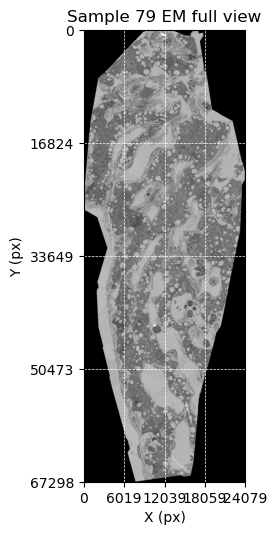

In [26]:

# Load once into memory
loader = SampleMasks(79)
loader.display_em()
# etc.


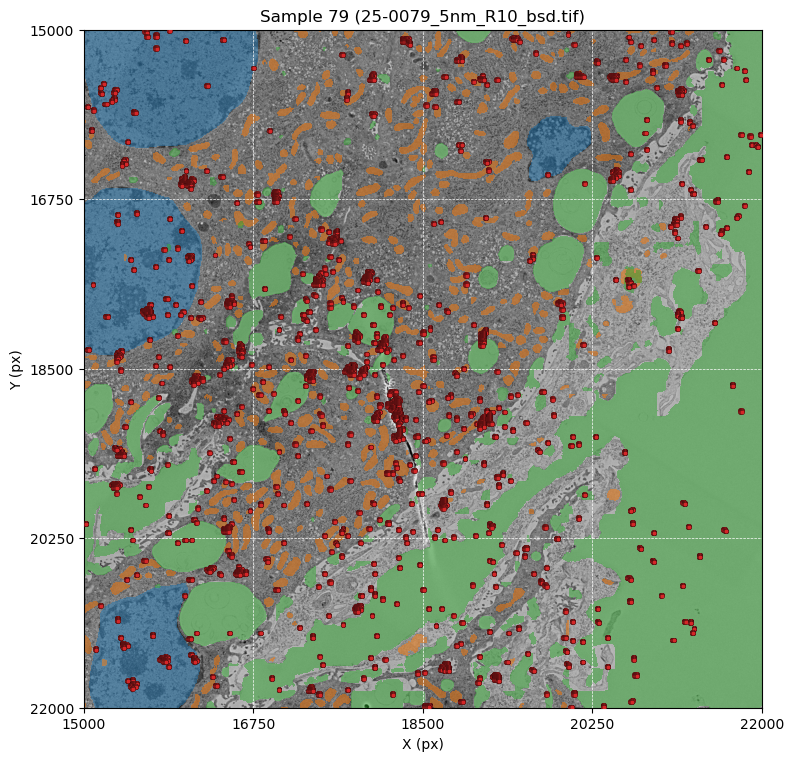

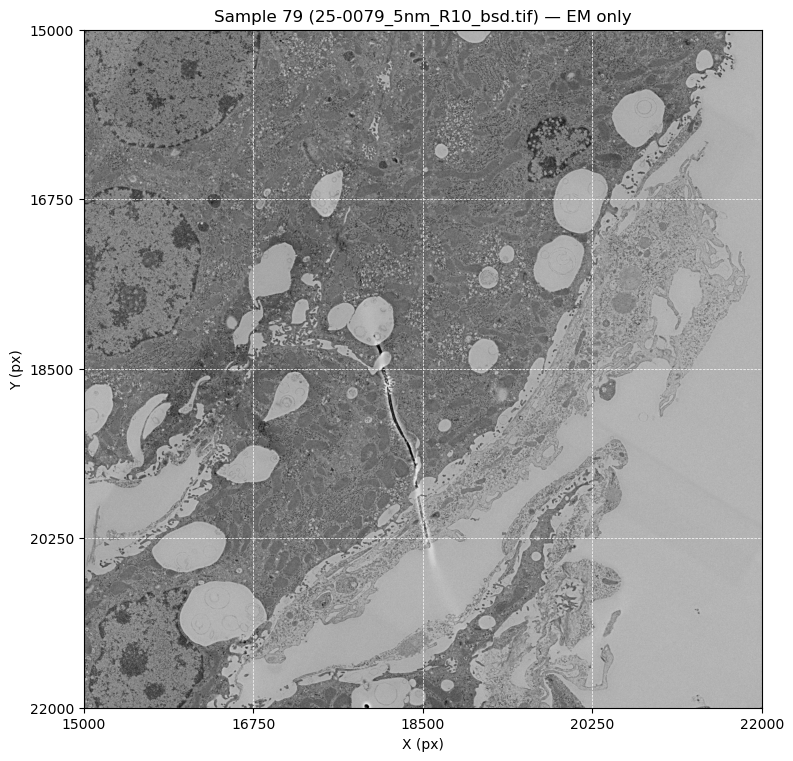

In [36]:
loader.display(((15000,15000), (22000,22000)), au_size=10, au_border=0.2)
loader.display(((15000,15000), (22000,22000)), em_only=True)

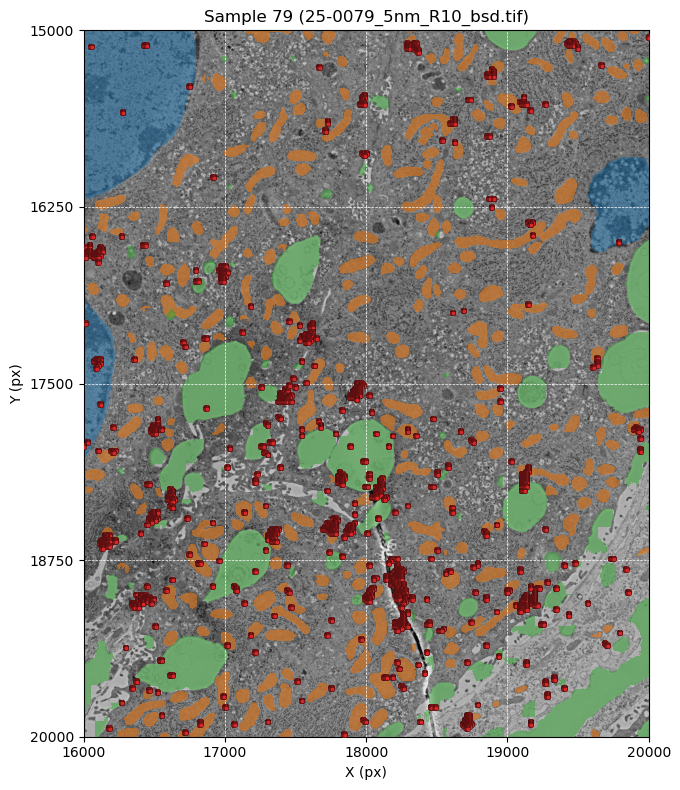

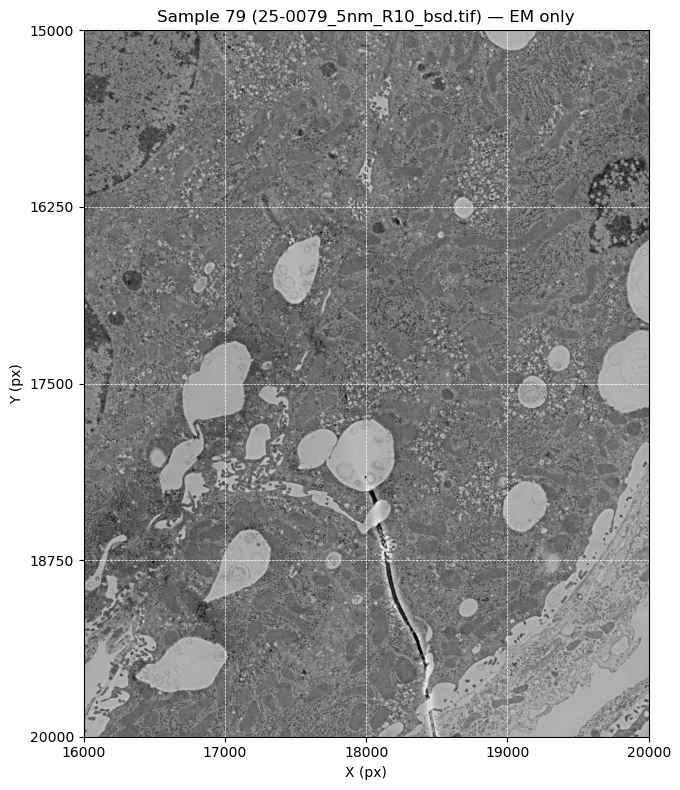

In [35]:
loader.display(((16000,15000), (20000,20000)), au_size=10, au_border=0.2)
loader.display(((16000,15000), (20000,20000)), em_only=True)

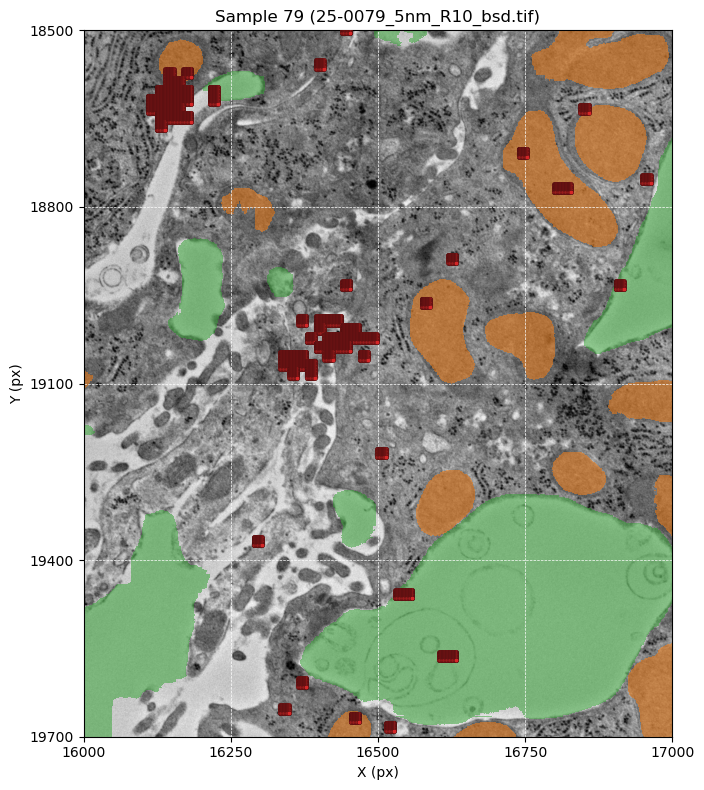

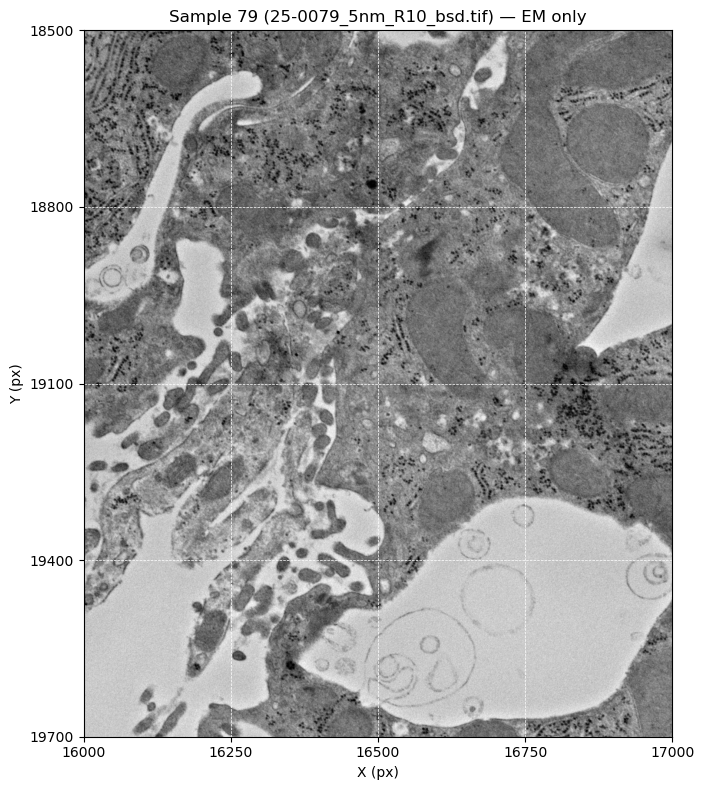

In [42]:
loader.display(((16000,18500), (17000,19700)), au_size=10, au_border=0.2)
loader.display(((16000,18500), (17000,19700)), em_only=True)